# Visualization of results of linking GWAS variants to HLCA cell types (Figure 5d, Extended Data Figure 13).

In this script we visualize the results from the LDSC analysis, linking GWAS variants from existing GWAS studies to HLCA cell types based on differentially expressed genes in those cell types.

## Import modules, set paths, import files:

In [1]:
import scanpy as sc
import pandas as pd
import sys
import numpy as np
import os
from statsmodels.stats.multitest import multipletests
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append("../../scripts/")
import celltype_composition_plotting
import reference_based_harmonizing

Optional, for pretty code formatting:

In [2]:
%load_ext lab_black

Set paths:

In [3]:
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_celltype_ref_mapping = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20221007.csv"
dir_LDSC_results = "../../results/LDSC_GWAS_to_celltype/ldsc_results/"
dir_figures = "../../results/figures/"

Load files:

In [4]:
adata = sc.read(path_HLCA)

get colormapping for paper:

In [5]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(
    path_celltype_ref_mapping
)
consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)

### Generate color map:

To generate a nice color map for the dots in the dot plot (coloring cells from the same compartment with the same color, but different shades), we'll generate a color mapping using the code below. 

In [6]:
color_df = celltype_composition_plotting.calculate_hierarchical_coloring_df(
    adata, consensus_df, max_level=5, ann_level_name_prefix="ann_level_"
)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Import GWAS data, perform p-value correction and prepare plot:

Import files, correct p-values for multiple-testing:

In [7]:
write_corr_pvalues_to_file = (
    False  # whether to write same results, but with corrected p-value, to a new file
)
# create dictionary for results per GWAS:
ldsc_outs = dict()
# store lung conditions of the included GWAS studies, and the matched naming
# used for the files:
conditions_and_file_prefixes = {
    "Lung function (fvc)": "Shrine_lung_function_fvc",
    "Asthma": "Han_asthma",
    "Lung adenocarcinoma": "McKay_lung_cancer_adenocarcinoma",
    "COPD": "Sakornsakolpat_COPD",
    "Depression": "Howard_depression",
    "IPF": "Allen_IPF",
}
# import results and perform p-value correction:
for condition, prefix in conditions_and_file_prefixes.items():
    ldsc_out = pd.read_csv(
        os.path.join(dir_LDSC_results, f"{prefix}_1000genes.cell_type_results.txt"),
        sep="\t",
        index_col=0,
    )
    _, ldsc_out["p_corr"], _, _ = multipletests(
        ldsc_out.Coefficient_P_value.values, alpha=0.05, method="fdr_bh"
    )
    ldsc_out.index = ldsc_out.index.str.replace(
        "Fibromyocytes", "Smooth muscle FAM83D+"
    )
    if write_corr_pvalues_to_file:
        ldsc_out.to_csv(
            os.path.join(
                dir_LDSC_results,
                f"{prefix}_1000genes.cell_type_results_with_corrpvals.csv",
            )
        )
    ldsc_outs[condition] = ldsc_out

For each annotation included in the analysis, get corresponding name in our level 1-5 annotations, plus the level itself. This will allow us to extract the right colors from our color_df, and order our cell types "biologically".

In [8]:
man_ann_to_ref_ann = dict()
man_ann_to_level = dict()

In [9]:
for ct in ldsc_out.index:
    ct_found = False
    for level in [2, 3, 4, 5]:
        level_cts = color_df[f"l{level}_label"].dropna().values
        for level_ct in level_cts:

            if ct.lower() == level_ct.lower():
                man_ann_to_ref_ann[ct] = level_ct
                man_ann_to_level[ct] = level
                ct_found = True
            elif ct.replace("_", " ").lower() == level_ct.lower():
                man_ann_to_ref_ann[ct] = level_ct
                man_ann_to_level[ct] = level
                ct_found = True
            elif ct.replace("_", " ").lower().strip("s") == level_ct.lower():
                man_ann_to_ref_ann[ct] = level_ct
                man_ann_to_level[ct] = level
                ct_found = True
            elif ct.replace("_", " ").lower() == level_ct.lower().strip("s"):
                man_ann_to_ref_ann[ct] = level_ct
                man_ann_to_level[ct] = level
                ct_found = True
            elif ct.strip("_cells").replace("_", " ").lower() == level_ct.lower():
                man_ann_to_ref_ann[ct] = level_ct
                man_ann_to_level[ct] = level
                ct_found = True
    if ct_found == False:
        print(f"{ct} not found")

Order annotations ('manual annotations' i.e. 'man_anns') based on hierarchical cell type reference.

In [10]:
man_ann_to_order_number = dict()
for ct in ldsc_out.index:
    ct_name = man_ann_to_ref_ann[ct]
    ct_level = man_ann_to_level[ct]
    man_ann_to_order_number[ct] = np.where(
        consensus_df[f"level_{ct_level}"] == ct_name
    )[0][0]
man_ann_ordered = [
    man_ann
    for order_number, man_ann in sorted(
        zip(man_ann_to_order_number.values(), man_ann_to_order_number.keys())
    )
]
for dis, ldsc_out in ldsc_outs.items():
    ldsc_outs[dis] = ldsc_out.loc[man_ann_ordered, :]

now get colors:

In [11]:
for dis, ldsc_out in ldsc_outs.items():
    ldsc_out["color"] = None
    for ct in ldsc_out.index:
        ct_level = man_ann_to_level[ct]
        ct_name = man_ann_to_ref_ann[ct]
        ldsc_out.loc[ct, "color"] = color_df.loc[
            color_df[f"l{ct_level}_label"] == ct_name, f"l{ct_level}_rgba"
        ].values
    ldsc_outs[dis] = ldsc_out

## plot:

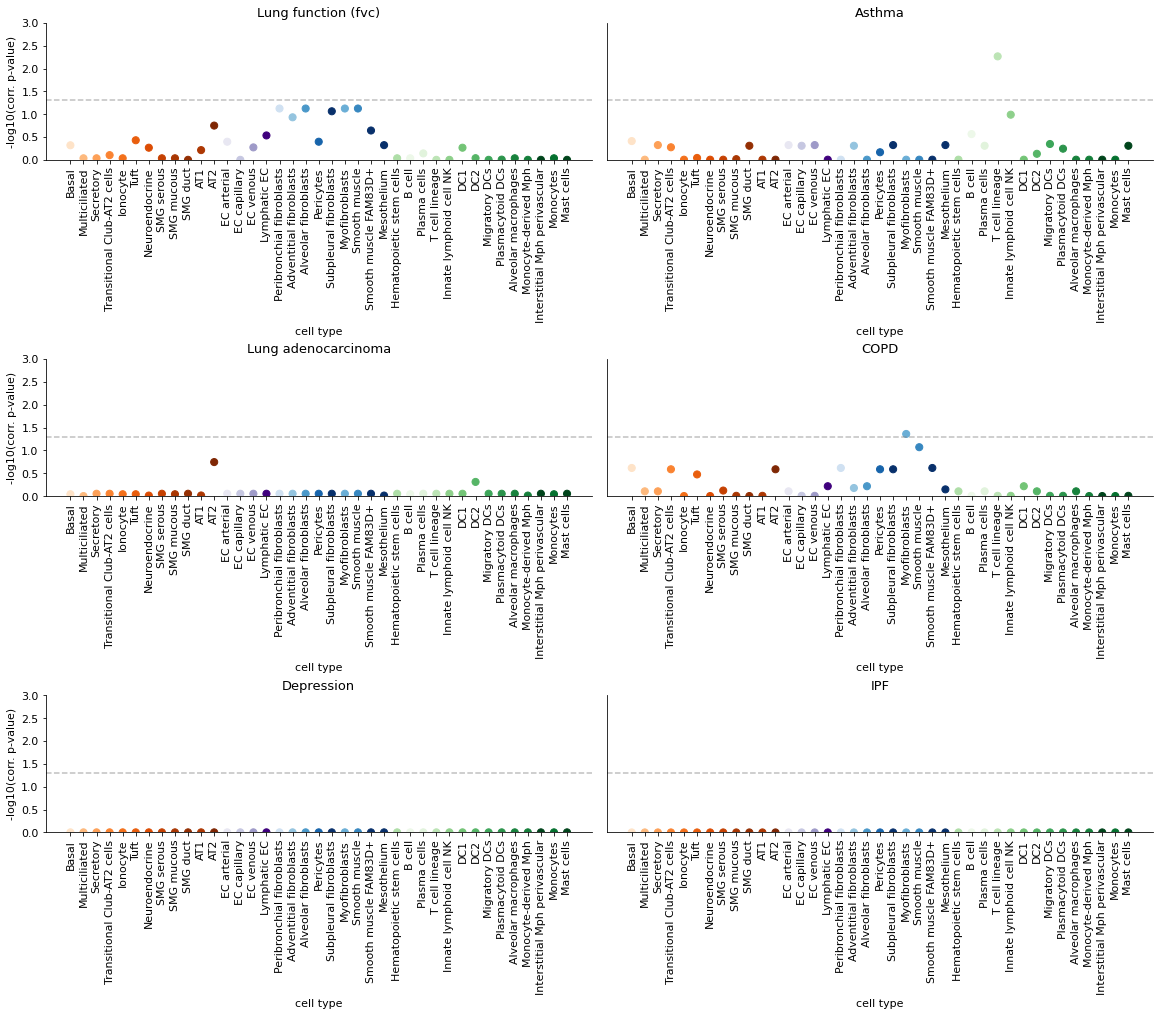

In [12]:
figwidth = 16
figheight = 14
fig = plt.figure(
    figsize=(figwidth, figheight),
    constrained_layout=True,
)
n_cols = 2
ymax = 3
n_rows = int(np.ceil(len(ldsc_outs) / n_cols))
gs = GridSpec(n_rows, n_cols, figure=fig)
fig_count = 0
fz = 11
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
    }
):
    for dis, ldsc_out in ldsc_outs.items():
        row = int(np.floor(fig_count / 2))
        col = fig_count % n_cols
        ax = fig.add_subplot(gs[row, col])
        ax.scatter(
            range(ldsc_out.shape[0]),
            -np.log10(ldsc_out.p_corr),
            c=[literal_eval(rgb_string) for rgb_string in ldsc_out.color.values],
            s=50,
        )
        ax.set_xlabel("cell type", fontsize=fz)
        ax.set_ylim((0, ymax))
        ax.tick_params(labelsize=fz)
        if col == 0:
            ax.set_ylabel("-log10(corr. p-value)", fontsize=fz)
        else:
            ax.set_yticks([])
        ax.set_title(dis, fontsize=fz + 2)
        ax.set_xticks(range(ldsc_out.shape[0]))
        ax.set_xticklabels(
            [ct.replace("_", " ") for ct in ldsc_out.index.values], rotation=90
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.axhline(-np.log10(0.05), linestyle="--", c="grey", alpha=0.5)
        fig_count += 1
        # ax.xticks(labels=ldsc_out.index)
    plt.show()
    plt.close()

If wanted, print top of results for a disease of choice:

In [13]:
ldsc_outs["Lung function (fvc)"].sort_values(by="p_corr").head(5)

,Coefficient,Coefficient_std_error,Coefficient_P_value,p_corr,color
Name,,,,,
Smooth_muscle,6.214809e-09,2.542157e-09,0.007249,0.074956,"(0.21568627450980393, 0.5294117647058824, 0.75..."
Myofibroblasts,7.046195e-09,2.674407e-09,0.004211,0.074956,"(0.41708573625528644, 0.6806305267204922, 0.83..."
Alveolar_fibroblasts,7.698498e-09,3.176320e-09,0.007681,0.074956,"(0.2909803921568628, 0.5945098039215686, 0.789..."
Peribronchial_fibroblasts,7.246031e-09,2.990018e-09,0.007688,0.074956,"(0.8141176470588235, 0.883921568627451, 0.9498..."
Subpleural_fibroblasts,8.125273e-09,3.550097e-09,0.011047,0.086167,"(0.03137254901960784, 0.18823529411764706, 0.4..."


In [14]:
ldsc_outs["Asthma"].sort_values(by="p_corr").head(5)

,Coefficient,Coefficient_std_error,Coefficient_P_value,p_corr,color
Name,,,,,
T_cell_lineage,2.347852e-08,6.459308e-09,0.000139,0.005424,"(0.7371472510572856, 0.895517108804306, 0.7108..."
Innate_lymphoid_cell_NK,1.268383e-08,4.956659e-09,0.005249,0.102365,"(0.5573241061130334, 0.8164244521337947, 0.546..."
B_cell,7.397485e-09,3.634793e-09,0.020916,0.271908,"(0.9287658592848904, 0.9727335640138408, 0.914..."
Basal,6.678114e-09,3.805341e-09,0.039635,0.386446,"(0.9955709342560554, 0.8907958477508651, 0.785..."
Migratory_DCs,4.497032e-09,2.852338e-09,0.057442,0.448050,"(0.2378316032295272, 0.6523798539023453, 0.351..."


In [15]:
ldsc_outs["Lung adenocarcinoma"].sort_values(by="p_corr").head(5)

,Coefficient,Coefficient_std_error,Coefficient_P_value,p_corr,color
Name,,,,,
AT2,1.424453e-08,5.469236e-09,0.004601,0.179425,"(0.4980392156862745, 0.15294117647058825, 0.01..."
DC2,1.146103e-08,5.847388e-09,0.024996,0.487430,"(0.3388235294117647, 0.7117262591311034, 0.405..."
Pericytes,2.435364e-09,4.528980e-09,0.295382,0.884434,"(0.09019607843137256, 0.39294117647058824, 0.6..."
Myofibroblasts,4.231863e-09,6.233001e-09,0.248586,0.884434,"(0.41708573625528644, 0.6806305267204922, 0.83..."
Smooth_muscle,-2.253581e-09,6.530826e-09,0.634978,0.884434,"(0.21568627450980393, 0.5294117647058824, 0.75..."


In [16]:
ldsc_outs["COPD"].sort_values(by="p_corr").head(5)

,Coefficient,Coefficient_std_error,Coefficient_P_value,p_corr,color
Name,,,,,
Myofibroblasts,1.163947e-08,3.807049e-09,0.001117,0.043545,"(0.41708573625528644, 0.6806305267204922, 0.83..."
Smooth_muscle,6.080526e-09,2.317475e-09,0.004348,0.084788,"(0.21568627450980393, 0.5294117647058824, 0.75..."
Basal,6.941618e-09,3.612588e-09,0.027334,0.241418,"(0.9955709342560554, 0.8907958477508651, 0.785..."
Smooth muscle FAM83D+,5.523712e-09,2.958608e-09,0.030951,0.241418,"(0.03137254901960784, 0.18823529411764706, 0.4..."
Peribronchial_fibroblasts,6.555452e-09,3.317169e-09,0.024065,0.241418,"(0.8141176470588235, 0.883921568627451, 0.9498..."


### store figure:

In [17]:
fig.savefig(
    os.path.join(dir_figures, "5d_ED15_GWAS_to_cell_type_results.png"),
    bbox_inches="tight",
)